In [1]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pprint as pp
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import heapq
import json
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
data = {}

json_list = os.listdir('bbg_json/')

In [2]:
for fname in tqdm(json_list):
    with open(os.path.join('bbg_json',fname), 'r') as f:
        data[fname.split('.')[0]] = json.load(f)

100%|██████████| 5968/5968 [00:05<00:00, 1007.80it/s]


In [3]:
def for_kids(game):
    return int(game['age']) < 8 and int(game['age']) > 0
kids_games = list(filter(for_kids, data.values()))


In [4]:
len(kids_games)

840

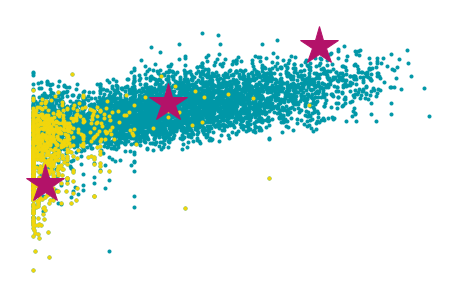

In [26]:
# Let's plot the average weight vs average score

plt.figure(figsize=(8,5))
plt.plot([g['stats']['averageweight'] for g in data.values()], [g['stats']['average'] for g in data.values()],'.', color = '#0097a7')
plt.plot([g['stats']['averageweight'] for g in kids_games], [g['stats']['average'] for g in kids_games],'.', color = '#F2D60C')

clue = next(filter(lambda x: x['name'].lower() == 'clue', data.values()))
catan = next(filter(lambda x: x['name'].lower() == 'catan', data.values()))
gloomhaven =  next(filter(lambda x: x['name'].lower() == 'gloomhaven', data.values()))
guess_who = data['4143']
for game in [guess_who, catan, gloomhaven]:
    plt.plot(game['stats']['averageweight'],game['stats']['average'], '*',markersize=40, color='#B31269')
plt.ylim(2,10)
plt.xlim(.75,None)
plt.axis('off')
#plt.savefig('kids_game_ratings.png', transparent=True, dpi=200)
#plt.savefig('game_ratings_with_games.png', transparent=True, dpi=200)
#plt.savefig('game_ratings.png', transparent=True, dpi=200)
plt.show()

In [8]:
#print(data['249421']['yearpublished'])
complexity = [g['stats']['averageweight'] for g in data.values()]
age =  [np.log(2021-float(g['yearpublished'])) for g in data.values()]
print(min(age))
X = np.array(list(zip(complexity,age)))

X1 = np.array(complexity).reshape(-1,1)
print(X.shape)
y= np.array([g['stats']['average'] for g in data.values()]).reshape(-1,1)


0.0
(5968, 2)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.2, random_state=0)

In [10]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train) #training the algorithm
regressor1 = LinearRegression()  
regressor1.fit(X1_train, y1_train) #training the algorithm


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [15]:
#To retrieve the intercept:
print(regressor.intercept_)#For retrieving the slope:
print(regressor.coef_)

[6.40152664]
[[ 0.54554561 -0.33604919]]


In [16]:
y_pred = regressor.predict(X_test)
y1_pred = regressor1.predict(X1_test)

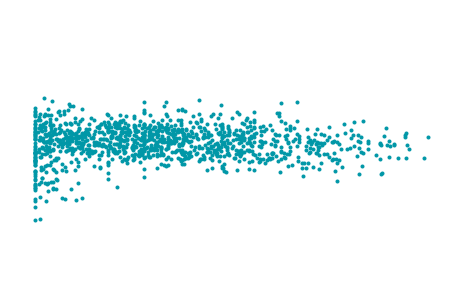

In [17]:
#plt.scatter(X_test[:,0], y_test,  color='gray')
#print((y[:,0]-regressor.coef_[0,0]*X_test[:,0]).shape)
#plt.plot(X_test[:,0], y_test-regressor.coef_[0,0]*X_test[:,0]-regressor.intercept_[0], '.', color='red', )
#plt.plot(X_test[:,0], y_test-y_pred , '.', color='black', )

plt.figure(figsize=(8,5))
plt.plot(X1_test[:,0], y1_test-y1_pred,'.', color = '#0097a7')
#plt.plot(X1_test[:,0], y1_test-y1_pred,'.', color = 'lightgray')

#plt.plot(X_test[:,0], y_test-y_pred,'.', color = '#0097a7')

#clue = next(filter(lambda x: x['name'].lower() == 'clue', data.values()))
#catan = next(filter(lambda x: x['name'].lower() == 'catan', data.values()))
#gloomhaven =  next(filter(lambda x: x['name'].lower() == 'gloomhaven', data.values()))
#guess_who = data['4143']
#for game in [guess_who, clue, catan, gloomhaven]:
#    plt.plot(game['stats']['averageweight'],game['stats']['average'], '*',markersize=40, color='#B31269')
plt.ylim(-5,5)
plt.xlim(.75,None)
plt.axis('off')
#plt.savefig('kids_game_ratings.png', transparent=True, dpi=200)
plt.savefig('complexity_residuals.png', transparent=True, dpi=200)
#plt.savefig('residuals.png', transparent=True, dpi=200)

#plt.savefig('game_ratings_with_games.png', transparent=True, dpi=200)
#plt.savefig('game_ratings.png', transparent=True, dpi=200)
plt.show()



In [18]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.39269416962159753
Mean Squared Error: 0.2712919604248176
Root Mean Squared Error: 0.5208569481391389


In [19]:
np.average(y_test)

6.7933188609715245

In [71]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']


In [29]:
n_comments = len(deduc_comments)
sum = 0
for elm in  map(sentiment_analyzer_scores, deduc_comments):
    sum += elm
print(sum/n_comments)

0.5633750000000001


In [93]:
def new_score(game, search_string, norm = 15.0,):
    rel_comments = filter(lambda x: search_string in x['comment'], game['comments'])
    rel_comments = list(map(lambda x: x['comment'], rel_comments))
    n_comments = len(rel_comments) 
    sum = 0
    if n_comments > 5:
        for elm in  map(sentiment_analyzer_scores, rel_comments):
            sum += elm
        return (game['stats']['average'] + sum/n_comments * norm)/2
    else:
        return -1

In [77]:
new_score(data['4143'],'deduc')

6.6179825

In [94]:
def return_n_best(N, search_string):
    return heapq.nlargest(N, map(lambda g: (new_score(g, search_string), g['name']), kids_games))


In [95]:
return_n_best(5, 'deduc')

[(8.78824, 'Barnyard Buddies'),
 (8.732835000000001, 'Kto to był?'),
 (8.458252727272725, 'Lisek urwisek'),
 (7.905735, 'Mastermind for Kids'),
 (7.877885714285714, 'Abraca... Boh!')]

In [96]:
return_n_best(5, 'learn')

[(10.47261, 'Carcassonne'),
 (10.4203625, 'Croa'),
 (10.374175000000001, 'Mijnlieff'),
 (10.35173, 'Lisek urwisek'),
 (10.293599999999998, 'Go Away Monster!')]

In [98]:
return_n_best(5, 'pattern')

[(9.75593, 'Chodí Pešek okolo'),
 (8.3795125, 'Six'),
 (7.785565000000002, 'Fazantenbal'),
 (7.734480000000001, 'Blink'),
 (7.632991923076924, 'Carrousel')]

In [99]:
return_n_best(5, 'memo')

[(9.6682025, 'Cappuccetto Rosso e il Lupo Cattivo'),
 (9.652515000000001, 'Geisterwäldchen'),
 (9.2816625, 'Battling Ships'),
 (8.998145909090908, 'Boo Who'),
 (8.927663333333333, 'Au Bal Masqué des Coccinelles')]